# Generate point cloud and estimate normals

In [5]:
import open3d as o3d
import numpy as np
import random
from sklearn.neighbors import NearestNeighbors
import pandas as pd
from sklearn.manifold import MDS
from matplotlib import pyplot as plt
import os

In [6]:
# Import the coordinates and the features that have been generated by dMaSIF-site

%cd -q masif_site_outputs
coords = np.load("1pgb_A_predcoords.npy")
features = np.load("1pgb_A_predfeatures_emb1.npy")


[WinError 2] The system cannot find the file specified: 'masif_site_outputs'


In [7]:
#create a PointCloud and add the points

pointcloud = o3d.geometry.PointCloud()
pointcloud.points = o3d.utility.Vector3dVector(coords)
#o3d.visualization.draw_geometries([pointcloud])

In [8]:
# Estimate the normals based on knn
pointcloud.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamKNN(knn = 5))
pointcloud.orient_normals_consistent_tangent_plane(k=5)

o3d.visualization.draw_geometries([pointcloud], point_show_normal = True)

In [9]:
#Extract the normals as numpy array
normals = np.asarray(pointcloud.normals)

In [10]:
#Make uniform coloring of pointcloud

colors = np.zeros((len(coords),3))
colors[:,1]= 0.5
colors[:,2]= 1

pointcloud.colors = o3d.utility.Vector3dVector(colors)
#o3d.visualization.draw_geometries([pointcloud])

# Select a center point around which to extract a geodesic patch

In [11]:
#Select a random point of the cloud, around which to draw a geodesic circle, set a geodesic radius
radius = 9
center_index = random.randint(0, len(coords)-1) 
center_coords = coords[center_index]
center_norm = normals[center_index]

In [12]:
center_index, center_coords, center_norm

(5275,
 array([13.117066, 10.763481, 33.29879 ], dtype=float32),
 array([ 0.49526729, -0.09279114,  0.86377087]))

# Select all points that are close to the center point and generate a graph

In [13]:
# Make a rough first selection with all points with euclidean distance < radius

first_sel = [center_index] # to save all the points that are within the non-geodesic radius

#loop through all the points and check what their distance to the selected center point is
for index, point in enumerate(coords):
    dist = np.linalg.norm(coords[center_index]-point)

    # select only those points that are close to the center point and calculate their geodesic distance
    if dist < radius and dist != 0:
        first_sel.append(index)
        
coords_sel = coords[first_sel]


In [14]:
def generate_graph(indeces, coords_sel, normals):

    '''Function that takes a set of points, with their label, coordinates and surface normals. Calculates for each point the 
    geodesic distance to its n nearest neighbors and saves that information in a dictionary representing a graph. '''
    
    knn = NearestNeighbors(n_neighbors=4)
    knn.fit(coords_sel)
    graph = {}
    
    #loop through each point that is within the radius and find its nearest neighbors and their euclidean distance
    for idx, point in enumerate(coords_sel):
        dist, neighbors = knn.kneighbors([point], return_distance=True)
        
        # loop through the nearest neighbors calculate their geodesic distance to the point chosen above
        # Add the geodesic distance to a graph-dictionary
        connected_nodes = []
        for index, neighbor in enumerate(neighbors[0]):
            geo_dist = dist[0][index]*(2-np.dot(normals[indeces[idx]], normals[indeces[neighbor]]))        
            #distances.at[ first_sel[idx] , first_sel[neighbor] ] = geo_dist
            if geo_dist !=0:
                connected_nodes.append((indeces[neighbor], geo_dist))

        graph[indeces[idx]]=connected_nodes                      
    
    return graph

In [15]:
graph = generate_graph(first_sel, coords_sel, normals)

In [16]:
def make_graph_bidirectional(graph):  

    '''The result of the generate_graph function is a graph where individual points can be "connected" to another point, but not
    vice-versa. This function detect unidirectional connections and adds the connection information to both involved points'''
    
    #loop through all the keys
    for key in graph:
        
        # loop through all the neighbors of the key and their distances to the key
        for p, d in graph[key]:
            # For each neighbor, set bidirectional = False
            bidirectional = False
            
            # check the graph entry of that neighbor, if there the key is among its connected points, set bidire = True
            for pt,_ in graph[p]:
                if pt == key:
                    bidirectional = True

            if not bidirectional:
                current_list = graph[p]
                current_list.append((key,d))
                graph[p]=current_list
                
    return graph

In [17]:
graph = make_graph_bidirectional(graph)

In [18]:
graph

{5275: [(5274, 0.32652863425756146),
  (5272, 0.37641599408499227),
  (5106, 0.5004690813428011),
  (5278, 0.8087463858727956)],
 2248: [(2434, 0.4251866087521346),
  (2431, 0.8800231662836414),
  (2643, 1.1762249483982805)],
 2254: [(2437, 0.25506777482406523),
  (2438, 0.6700698257977102),
  (2441, 0.7668288083566202)],
 2267: [(2444, 0.3465507074060096),
  (2441, 0.3891092458610113),
  (2442, 0.842260025050435)],
 2427: [(2428, 0.28456771980114093),
  (2431, 0.4237828612758479),
  (2636, 0.7158119793590467)],
 2428: [(2427, 0.28456771980114093),
  (2637, 0.48684338265385707),
  (2636, 0.5399442088499704),
  (2431, 0.7030791883409913)],
 2431: [(2427, 0.4237828612758479),
  (2428, 0.7030791883409913),
  (2248, 0.8800231662836414)],
 2434: [(2248, 0.4251866087521346),
  (2643, 0.623175912895632),
  (2640, 0.950691799162377)],
 2437: [(2254, 0.25506777482406523),
  (2438, 0.43610379135129085),
  (2442, 0.7429686758620687)],
 2438: [(2437, 0.43610379135129085),
  (2442, 0.62737516356537

# Run dijkstra algorithm on the graph and find the geodesic distance of each node to the center node

In [19]:
def dijkstra(graph, center):
    
    '''Function that takes a graph and the starting node and returns a list of distances 
    from the starting node to every other node'''

    n = len(graph) # How many nodes are in the graph?
    
    # initialize a dictionary to save the distances of each node from the start node
    dist_from_center = {}
    for key in graph:
        dist_from_center[key]=1000
        
    # initialize a dictionary to save which node has been visited already
    visited={}
    for key in graph:
        visited[key]=False
            
    # set the distance for the start to be 0
    dist_from_center[center] = 0
    
    
    
    for p in range(n):
        
        
        # loop through all the nodes to check which one is not yet visited and has the lowest distance to the current node
        u = -1
        for key in graph:
            # if the node 'key' hasn't been visited and
            # we haven't processed it or the distance we have for it is less
            # than the distance we have to the "start" node
            
            # our start node (4557) will be selected first and assigned to u
            if not visited[key] and (u == -1 or dist_from_center[key] < dist_from_center[u]):
                u = key 
        
        
        # all the nodes have been visited or we can't reach this node
        if dist_from_center[u] == 1000:
            #print("break")
            break
        
        # set the node as visited
        visited[u] = True
        
        # from the current selected node u, check what the distances to the next nodes are and update their dist from center
        # loop through all the points (and their weights) that can be reached from our current node
        for v, l in graph[u]:
            if dist_from_center[u] + l < dist_from_center[v]:
                dist_from_center[v] = dist_from_center[u] + l
    return dist_from_center

In [20]:
dist_from_center = dijkstra(graph, center_index)

In [21]:
dist_from_center

{5275: 0,
 2248: 12.049836068069729,
 2254: 13.267633981585629,
 2267: 13.073506137155553,
 2427: 11.43103852670069,
 2428: 11.14733672197983,
 2431: 11.850415910320821,
 2434: 11.624649459317594,
 2437: 13.012566206761564,
 2438: 12.600905773134905,
 2441: 12.684396891294542,
 2442: 12.269597530899496,
 2444: 12.817683402184679,
 2445: 12.278190626868607,
 2452: 12.347502222042188,
 2453: 11.91179992748794,
 2459: 12.794012989470188,
 2460: 12.398527323727723,
 2629: 11.95973956074131,
 2631: 11.566888480838362,
 2632: 11.270154064005258,
 2633: 10.731210439917891,
 2636: 10.715226547341643,
 2637: 10.660493339325972,
 2640: 10.673957660155217,
 2643: 11.762018029812097,
 2647: 10.883957836417185,
 2648: 11.006650475685355,
 2651: 11.82328909558694,
 2652: 11.374622178073036,
 2654: 11.840960376869129,
 2655: 11.557273004506948,
 2659: 11.947084478596514,
 2660: 11.500920193415551,
 2665: 13.114395229225186,
 2666: 12.361760772138798,
 2667: 11.823540771913285,
 2668: 11.6047661190758

## Keep only the points that are within the geodesic radius. Use the results of the djikstra algorithm

In [22]:
# Collect the indeces of the points that are < radius away from the center point
patch_indeces = []

for key in dist_from_center:
    if dist_from_center[key]<=radius:
        patch_indeces.append(key)
        
patch_coords = coords[patch_indeces]
patch_features = features[patch_indeces]
patch_normals = normals[patch_indeces]

## Visualize the new geodesic patch

In [23]:
colors[patch_indeces]=np.asarray([1,0.5,0])
colors[center_index]=np.asarray([1,0,0])

In [24]:
pointcloud.colors = o3d.utility.Vector3dVector(colors)
o3d.visualization.draw_geometries([pointcloud])

[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 


In [25]:
#create a visualization of the "patchcloud"

patchcloud = o3d.geometry.PointCloud()
patchcloud.points = o3d.utility.Vector3dVector(patch_coords)

patchcolors = np.zeros((len(patch_coords),3))
patchcolors[:,1]= 0.5
patchcolors[:,2]= 1
patchcolors[0,:]=np.asarray([1,0,0])
patchcolors
patchcloud.colors = o3d.utility.Vector3dVector(patchcolors)

#visualize
o3d.visualization.draw_geometries([patchcloud])

[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 


# Make a graph from the extracted patch

In [26]:
patch_graph = generate_graph(patch_indeces, patch_coords, normals)

In [27]:
patch_graph = make_graph_bidirectional(patch_graph)

# Generate pairwise distance matrix

In [28]:
# Generate a double dictionare where the distance between two points can be accessed with dict[point1][point2]

pairwise_dist_dict = {}
for key in patch_graph:
    distances = dijkstra(patch_graph, key)
    pairwise_dist_dict[key]=distances
    

In [29]:
# Generate a quadratic dataframe for the pairwise distances between all points, label the columns and rows accordingly

pairwise_distances = pd.DataFrame(np.zeros((len(patch_indeces),len(patch_indeces))))
pairwise_distances.columns = patch_indeces
pairwise_distances.index = patch_indeces

In [30]:
# Add the distance information stored in the pairwise_dist_dict to the dataframe

for index in patch_indeces:
    for idx in patch_indeces:
        pairwise_distances.at[index, idx] = pairwise_dist_dict[index][idx]

In [31]:
pairwise_distances

,5275,3098,3100,3102,3112,3113,3118,3119,3120,3350,...,5799,5802,5803,5806,5807,5983,5991,5992,5999,6000
5275,0.000000,8.949146,8.922963,8.700827,8.332276,8.224567,8.625683,8.819053,8.690173,8.448253,...,6.855656,7.382571,6.528524,7.204222,7.078003,8.092940,8.818623,8.564298,8.194981,7.763463
3098,8.949146,0.000000,0.653079,1.389686,4.804239,6.660955,7.062071,7.255441,7.884442,1.320036,...,15.012396,15.775406,15.278265,15.953963,15.827745,16.249680,16.975363,16.721038,16.351721,15.920203
3100,8.922963,0.653079,0.000000,0.736608,4.447988,6.304704,6.705820,6.899190,7.528191,1.818584,...,14.986214,15.749224,15.252083,15.927781,15.801563,16.223498,16.949181,16.694856,16.325539,15.894021
3102,8.700827,1.389686,0.736608,0.000000,3.711381,5.568096,5.969213,6.162582,6.791584,2.478908,...,14.764078,15.527087,15.029947,15.705645,15.579426,16.001362,16.727045,16.472719,16.103402,15.671884
3112,8.332276,4.804239,4.447988,3.711381,0.000000,1.856716,2.257832,2.451202,3.080203,4.937211,...,14.850293,15.377208,14.523160,15.198858,15.072640,16.087577,16.813260,16.558935,16.189618,15.758099
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5983,8.092940,16.249680,16.223498,16.001362,16.087577,15.979868,16.380984,15.937893,15.587437,15.748787,...,2.353496,2.268929,3.122977,3.225142,3.813640,0.000000,0.725683,0.785236,1.395935,1.586071
5991,8.818623,16.975363,16.949181,16.727045,16.813260,16.705551,17.106667,16.663576,16.313120,16.474471,...,2.763690,2.538741,3.392789,3.494954,4.083452,0.725683,0.000000,1.149326,1.424365,1.855884
5992,8.564298,16.721038,16.694856,16.472719,16.558935,16.422856,16.432510,15.828370,15.477914,16.220145,...,1.708642,1.483693,2.337741,2.439906,3.028404,0.785236,1.149326,0.000000,0.610699,0.800835
5999,8.194981,16.351721,16.325539,16.103402,16.189618,16.053539,16.063193,15.459053,15.108597,15.850828,...,1.339325,1.114376,1.968424,2.070589,2.659087,1.395935,1.424365,0.610699,0.000000,0.431518


# Make embedding into 2D with MDS

In [32]:
mds = MDS(dissimilarity='precomputed', random_state=0)
# Get the embeddings
embedding = mds.fit_transform(pairwise_distances)

In [33]:
embedding

array([[-0.28062406,  0.50795321],
       [-5.22766834, -6.97722642],
       [-4.77476736, -7.07470037],
       [-4.18454222, -6.85599877],
       [-0.32273133, -7.37356789],
       [ 1.67126678, -7.3457841 ],
       [ 2.00926043, -7.58542928],
       [ 2.6253819 , -7.26026448],
       [ 3.25114151, -6.90336483],
       [-5.43054323, -6.37349057],
       [-4.99584117, -6.21387343],
       [-4.53299586, -6.29909516],
       [-3.94839363, -6.13210896],
       [-3.51607532, -6.03095678],
       [-2.46702985, -6.62188068],
       [ 0.1475242 , -5.97487523],
       [ 0.33756445, -5.8479046 ],
       [-1.00052424, -6.65698004],
       [-0.38584575, -6.41251112],
       [ 1.03499152, -6.11529435],
       [ 0.2118298 , -7.15744795],
       [ 0.97474747, -6.76154072],
       [ 1.25793814, -7.24044229],
       [ 2.98053276, -5.89108946],
       [ 3.27937812, -6.53852192],
       [ 3.77285693, -6.59990816],
       [ 4.51829724, -6.37896823],
       [ 4.91075792, -6.01019818],
       [-5.03792958,

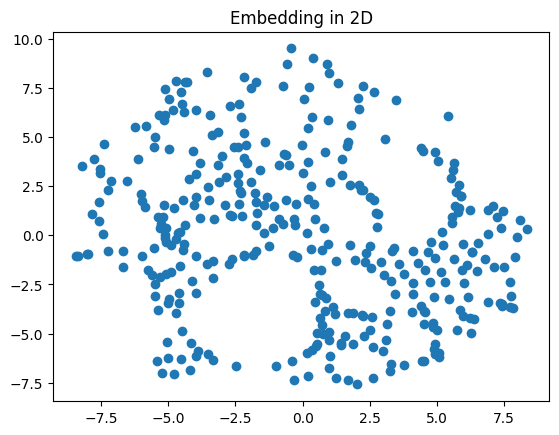

In [34]:
plt.scatter(embedding[:,0], embedding[:,1])
plt.title('Embedding in 2D')
plt.show()